In [3]:
# Load generated answers and uncertainty measures
import pickle

with open("../data/semantic_uncertainty_paraphrases.pkl", "rb") as file:
    uncertainty_results = pickle.load(file)
uncertainty_measures = uncertainty_results['uncertainty_measures']

with open("../data/train_multiquestion_generations.pkl", "rb") as file:
    questions_answers = pickle.load(file)

In [5]:
print(uncertainty_results.keys())
print(uncertainty_measures.keys())

dict_keys(['uncertainty_measures', 'example_ids', 'original_semantic_ids', 'all_semantic_ids', 'is_false', 'unanswerable'])
dict_keys(['p_false', 'p_false_fixed', 'original_cluster_assignment_entropy', 'all_cluster_assignment_entropy', 'original_regular_entropy', 'all_regular_entropy', 'original_semantic_entropy', 'all_semantic_entropy'])


In [18]:
# Calculate AUROC for each measure
from sklearn.metrics import roc_auc_score

# p_false v.s. p_false_fixed? I think 1-log(P(true)) vs 1-P(true)
methods = ['p_false_fixed', 'original_semantic_entropy', 'all_semantic_entropy']
method_clean_names = ['P(false)', 'SE', 'Paraphrase-Augmented SE']
AUROCs = []
for m in methods:
    AUROCs.append(roc_auc_score(uncertainty_results['is_false'], uncertainty_measures[m]))

print(AUROCs)

[0.7479110962566845, 0.7829211229946523, 0.7898423573975045]


(0.7, 0.8293344752673798)

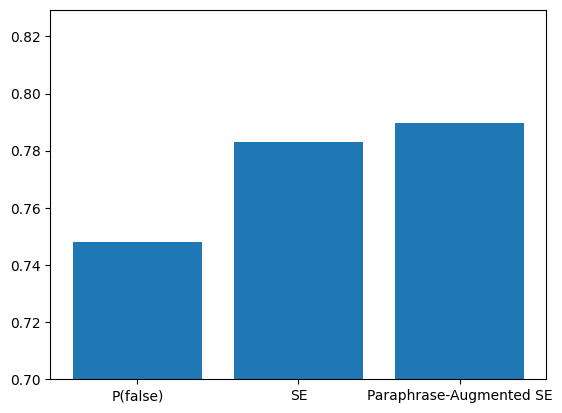

In [20]:
import matplotlib.pyplot as plt

plt.bar(method_clean_names, AUROCs)
plt.ylim(bottom=0.7)

In [24]:
questions_answers['qw_9705--33/33_1167073.txt#0_1']['question_and_paraphrases']

['"Who was known in the 1991 Gulf War as ""Stormin\' Norman""?"',
 'Which military leader was famously nicknamed "Stormin\' Norman" during the 1991 Gulf War?',
 'Whose moniker "Stormin\' Norman" became well-known during the 1991 Gulf War?',
 'In the 1991 Gulf War, who was referred to as "Stormin\' Norman"?']

In [32]:
# Compare performances for different number of valid paraphrases

# Get number of valid questions for each example (original + 0-3 paraphrases)
num_q = [len(questions_answers[ex_id]['question_and_paraphrases']) for ex_id in uncertainty_results['example_ids']]

# Get list of indices with n valid question versions for n = 1, 2, 3, 4
indices_by_num_q = {1:[], 2:[], 3:[], 4:[]}
for i, num in enumerate(num_q):
    indices_by_num_q[num].append(i)

print({num: len(indices_by_num_q[num]) for num in range(1, 5)})

{1: 61, 2: 61, 3: 90, 4: 188}


In [45]:
# Calculate AUC for each metric on each subset of examples (grouped by number of questions)
auroc_by_num_q = {m: [] for m in ['original_semantic_entropy', 'all_semantic_entropy']}

aurocs_by_num_q_flat = []
metrics_flat = []
num_q_flat = []

for num_q in range(1, 5):
    is_false = [uncertainty_results['is_false'][i] for i in indices_by_num_q[num_q]]
    for m, m_clean in [('original_semantic_entropy', 'SE'), ('all_semantic_entropy', 'Paraphrase SE')]:
        metric = [uncertainty_measures[m][i] for i in indices_by_num_q[num_q]]
        auroc_by_num_q[m].append(roc_auc_score(is_false, metric))

        aurocs_by_num_q_flat.append(auroc_by_num_q[m][-1])
        metrics_flat.append(m_clean)
        num_q_flat.append(num_q)

print(auroc_by_num_q)

{'original_semantic_entropy': [0.8308823529411764, 0.7523310023310024, 0.8206670311645708, 0.7685668156979633], 'all_semantic_entropy': [0.8308823529411764, 0.7144522144522145, 0.8059048660470203, 0.8021609538002982]}


<Axes: xlabel='Num q', ylabel='AUROC'>

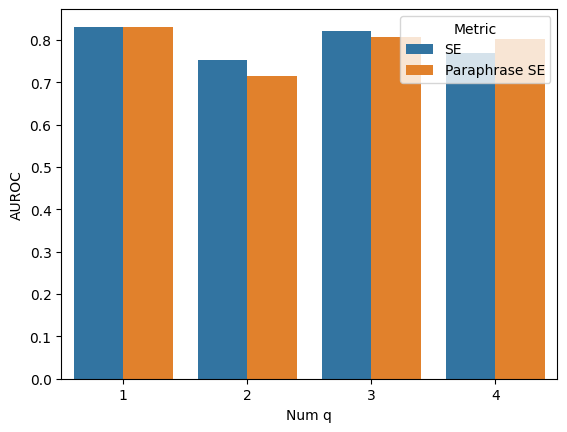

In [46]:
import seaborn as sns
sns.barplot(data={"Num q":num_q_flat, "AUROC": aurocs_by_num_q_flat, "Metric": metrics_flat}, x="Num q", y="AUROC", hue="Metric")
# plt.bar([1, 2, 3, 4], auroc_by_num_q['all_semantic_entropy'])